## Лабораторна робота №3: Дослідження варіантів архітектур згорткових нейронних мереж

In [2]:
# Imports and Global Settings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from typing import Tuple, Dict, List, Union, Optional
import time
from pathlib import Path
import matplotlib.pyplot as plt

# Set default device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure reproducibility
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
np.random.seed(42)

### Підготовка даних
Для експерименту було обрано датасет CIFAR-10, який містить 60 000 кольорових зображень розміром 32x32 пікселі, розділених на 10 класів. Датасет автоматично завантажується через torchvision та розділяється на навчальну (45 000 зображень), валідаційну (5 000 зображень) та тестову (10 000 зображень) вибірки. Для покращення узагальнення моделі застосовано аугментацію даних: випадкове обрізання з відступом та горизонтальне відображення.

In [3]:
# Data Preparation and Loading

def prepare_cifar10(
    batch_size: int = 128, 
    validation_split: float = 0.1,
    random_seed: int = 42,
    transform_train: Optional[transforms.Compose] = None,
    transform_val: Optional[transforms.Compose] = None
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict]:
    """
    Prepares CIFAR10 dataset with train/val/test splits and given transforms.
    """
    
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Default transforms if none provided
    if transform_train is None:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),  # Channel-wise means and stds of the CIFAR-10 dataset
                                 (0.2023, 0.1994, 0.2010))
        ])
    if transform_val is None:
        transform_val = transform_train
    
    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_val
    )
    
    # Split train into train/val
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_split * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=val_sampler,
        num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )
    
    dataset_info = {
        'num_classes': 10,
        'num_channels': 3,
        'image_size': 32,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'test_size': len(test_dataset),
    }
    return train_loader, val_loader, test_loader, dataset_info

### Реалізація архітектур
Реалізовано дві популярні архітектури згорткових нейронних мереж:
VGG11 - мережа з послідовними згортковими шарами та максимальним пулінгом. Особливістю є використання малих фільтрів 3x3 та поступове збільшення кількості каналів. Архітектуру адаптовано для роботи з CIFAR-10.
ResNet18 - глибока мережа з залишковими з'єднаннями (skip connections), що допомагають боротися з проблемою зникаючого градієнта. Складається з послідовності базових блоків, кожен з яких містить два згорткових шари та з'єднання для пропуску даних.

In [4]:
# Model Definitions (VGG11 and ResNet18)

class VGG11(nn.Module):
    """
    VGG11 variant for CIFAR10 with batch norm.
    """
    def __init__(self, num_classes: int = 10, init_weights: bool = True):
        super(VGG11, self).__init__()
        self.features = self._make_layers([
            64, 'M', 
            128, 'M', 
            256, 256, 'M', 
            512, 512, 'M', 
            512, 512, 'M'
        ])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()

    def _make_layers(self, cfg: List[Union[int, str]]) -> nn.Sequential:
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class BasicBlock(nn.Module):
    expansion: int = 1
    def __init__(self, in_planes: int, planes: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, 
                          bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)


class ResNet18(nn.Module):
    """ResNet18 for CIFAR-10."""
    def __init__(self, num_classes: int = 10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._initialize_weights()

    def _make_layer(self, planes: int, num_blocks: int, stride: int):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, s))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [5]:
def print_model_architecture(model, model_name):
    """Prints model architecture with parameter count."""
    print(f"\n{'-'*20} {model_name} Architecture {'-'*20}")
    print(model)
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'-'*20} Parameter Count {'-'*20}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"{'-'*60}\n")

# Initialize models
vgg_model = VGG11()
resnet_model = ResNet18()

# Print architectures
print_model_architecture(vgg_model, "VGG11")
print_model_architecture(resnet_model, "ResNet18")


-------------------- VGG11 Architecture --------------------
VGG11(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [6]:
# Training Utilities (train, validate, plot)

class AverageMeter:
    """Tracks and stores averages and current values."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = self.sum = self.count = 0
        self.avg = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    model.train()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        
        losses.update(loss.item(), inputs.size(0))
        accuracy.update(correct / inputs.size(0), inputs.size(0))
    return losses.avg, accuracy.avg

def validate(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            
            losses.update(loss.item(), inputs.size(0))
            accuracy.update(correct / inputs.size(0), inputs.size(0))
    return losses.avg, accuracy.avg

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str,
    patience: int,
    weight_decay: float,
    model_name: str = "model"
) -> Dict[str, List[float]]:
    device = torch.device(device)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                          momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', patience=4)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_times': []
    }

    save_dir = Path('model_checkpoints')
    save_dir.mkdir(exist_ok=True)

    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_path = save_dir / f'best_{model_name}.pth'
    
    print(f"\n--- Training {model_name} ---")
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc*100:.2f}% "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}% "
              f"Time: {epoch_time:.2f}s LR: {current_lr:.6f}")

    # Save final model
    final_model_path = save_dir / f'final_{model_name}.pth'
    torch.save(model.state_dict(), final_model_path)

    return history

def plot_training_history(history: Dict[str, List[float]], title: str):
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Навчання моделей
Обидві мережі навчалися з використанням SGD оптимізатора з моментом 0.9 та weight decay 1e-4. Початкова швидкість навчання встановлена на рівні 0.01 з автоматичним зменшенням при відсутності покращення валідаційної помилки. Для запобігання перенавчання використано ранню зупинку з терпінням 15 епох.

In [8]:
# Train & Evaluate VGG11

# Data augmentation & normalization for training
transform_train_vgg = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

transform_val_vgg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

vgg_train_loader, vgg_val_loader, vgg_test_loader, vgg_dataset_info = prepare_cifar10(
    batch_size=128,
    validation_split=0.1,
    random_seed=42,
    transform_train=transform_train_vgg,
    transform_val=transform_val_vgg
)

vgg_model = VGG11(num_classes=10)
vgg_history = train_model(
    model=vgg_model,
    train_loader=vgg_train_loader,
    val_loader=vgg_val_loader,
    num_epochs=100,
    learning_rate=0.01,
    device=device,
    patience=15,
    weight_decay=1e-4,
    model_name="vgg11"
)

Files already downloaded and verified
Files already downloaded and verified

--- Training vgg11 ---
Epoch [1/100] Train Loss: 1.6175 Train Acc: 38.94% Val Loss: 1.3641 Val Acc: 49.52% Time: 14.22s LR: 0.010000
Epoch [2/100] Train Loss: 1.1465 Train Acc: 58.68% Val Loss: 1.1513 Val Acc: 58.06% Time: 13.41s LR: 0.010000
Epoch [3/100] Train Loss: 0.9601 Train Acc: 66.04% Val Loss: 0.8772 Val Acc: 69.00% Time: 13.86s LR: 0.010000
Epoch [4/100] Train Loss: 0.8399 Train Acc: 70.44% Val Loss: 0.8199 Val Acc: 71.00% Time: 13.47s LR: 0.010000
Epoch [5/100] Train Loss: 0.7500 Train Acc: 73.66% Val Loss: 0.8659 Val Acc: 69.96% Time: 13.15s LR: 0.010000
Epoch [6/100] Train Loss: 0.6897 Train Acc: 76.00% Val Loss: 0.7654 Val Acc: 73.58% Time: 13.23s LR: 0.010000
Epoch [7/100] Train Loss: 0.6351 Train Acc: 77.95% Val Loss: 0.6643 Val Acc: 77.14% Time: 13.30s LR: 0.010000
Epoch [8/100] Train Loss: 0.5965 Train Acc: 79.42% Val Loss: 0.6192 Val Acc: 78.62% Time: 13.66s LR: 0.010000
Epoch [9/100] Train 

In [9]:
# Train & Evaluate ResNet18

transform_train_resnet = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

transform_val_resnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

resnet_train_loader, resnet_val_loader, resnet_test_loader, resnet_dataset_info = prepare_cifar10(
    batch_size=128,
    validation_split=0.1,
    random_seed=42,
    transform_train=transform_train_resnet,
    transform_val=transform_val_resnet
)

resnet_model = ResNet18(num_classes=10)
resnet_history = train_model(
    model=resnet_model,
    train_loader=resnet_train_loader,
    val_loader=resnet_val_loader,
    num_epochs=100,
    learning_rate=0.01,
    device=device,
    patience=15,
    weight_decay=1e-4,
    model_name="resnet18"
)

Files already downloaded and verified
Files already downloaded and verified

--- Training resnet18 ---
Epoch [1/100] Train Loss: 1.6595 Train Acc: 37.71% Val Loss: 1.4216 Val Acc: 48.86% Time: 19.68s LR: 0.010000
Epoch [2/100] Train Loss: 1.1928 Train Acc: 57.11% Val Loss: 1.1977 Val Acc: 57.82% Time: 19.15s LR: 0.010000
Epoch [3/100] Train Loss: 0.9360 Train Acc: 66.76% Val Loss: 0.9719 Val Acc: 66.20% Time: 19.58s LR: 0.010000
Epoch [4/100] Train Loss: 0.7729 Train Acc: 72.70% Val Loss: 0.9121 Val Acc: 68.84% Time: 19.15s LR: 0.010000
Epoch [5/100] Train Loss: 0.6758 Train Acc: 76.20% Val Loss: 0.6540 Val Acc: 77.04% Time: 19.15s LR: 0.010000
Epoch [6/100] Train Loss: 0.5923 Train Acc: 79.31% Val Loss: 0.5879 Val Acc: 80.16% Time: 19.38s LR: 0.010000
Epoch [7/100] Train Loss: 0.5467 Train Acc: 81.18% Val Loss: 0.5891 Val Acc: 79.52% Time: 19.11s LR: 0.010000
Epoch [8/100] Train Loss: 0.5004 Train Acc: 82.36% Val Loss: 0.5957 Val Acc: 79.88% Time: 18.99s LR: 0.010000
Epoch [9/100] Tra

### Порівняння результатів
Проведено порівняльний аналіз обох архітектур. ResNet18 показав кращі результати на тестовому наборі даних, досягнувши точності 91.30% порівняно з 88.34% для VGG11. Це підтверджує ефективність залишкових з'єднань для навчання глибоких мереж. Графіки навчання демонструють, що ResNet18 також краще узагальнює дані, показуючи меншу різницю між навчальною та валідаційною точністю.

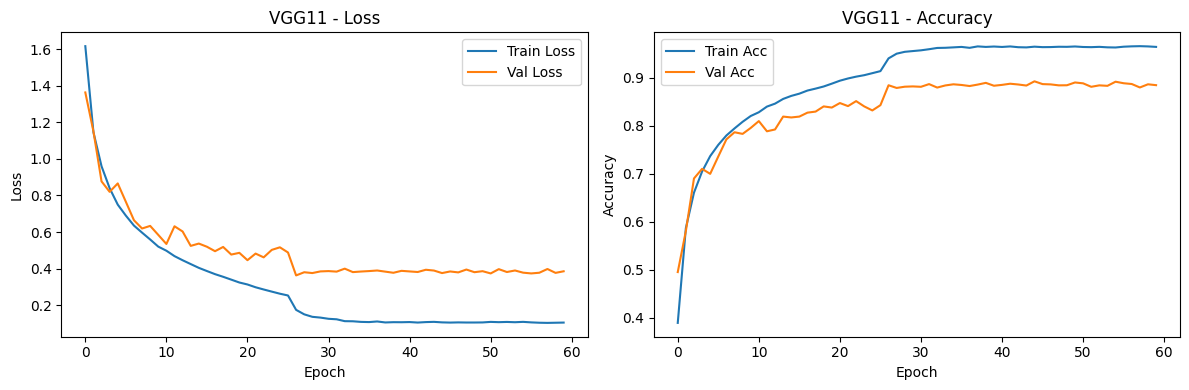

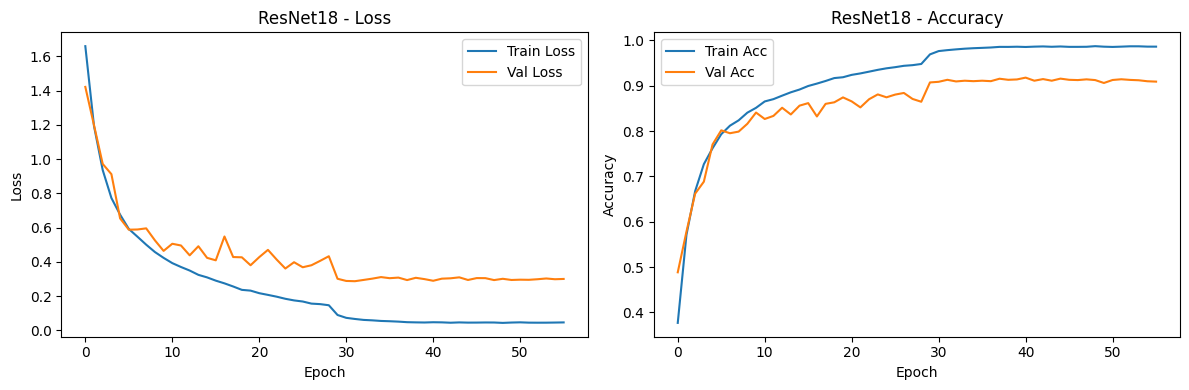

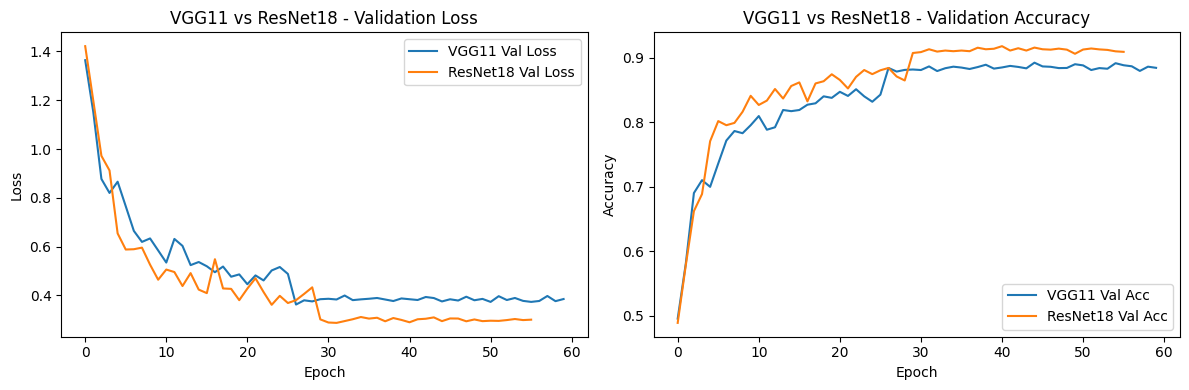

Comparison complete. Check the plots above.


In [10]:
# Compare Performance Side-by-Side

# Plot VGG11 training curves
plot_training_history(vgg_history, title="VGG11")

# Plot ResNet18 training curves
plot_training_history(resnet_history, title="ResNet18")

# Side-by-side comparison
# We'll create a combined plot for val accuracy and val loss for direct comparison

plt.figure(figsize=(12,4))

# Validation Loss
plt.subplot(1,2,1)
plt.plot(vgg_history['val_loss'], label='VGG11 Val Loss')
plt.plot(resnet_history['val_loss'], label='ResNet18 Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG11 vs ResNet18 - Validation Loss')
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
plt.plot(vgg_history['val_acc'], label='VGG11 Val Acc')
plt.plot(resnet_history['val_acc'], label='ResNet18 Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG11 vs ResNet18 - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Comparison complete. Check the plots above.")

In [11]:
# Evaluate Models on Test Dataset

def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluate the model on the test dataset.
    
    Args:
        model: Trained model.
        test_loader: DataLoader for test data.
        criterion: Loss function.
        device: Computation device.
    
    Returns:
        Tuple containing average loss and accuracy.
    """
    model.eval()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            
            losses.update(loss.item(), inputs.size(0))
            accuracy.update(correct / inputs.size(0), inputs.size(0))
    
    return losses.avg, accuracy.avg

def load_model_checkpoint(model: nn.Module, checkpoint_path: Path):
    """
    Load model weights from a checkpoint.
    
    Args:
        model: Model architecture.
        checkpoint_path: Path to the checkpoint file.
    """
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    model.to(device)
    model.eval()

# Paths to the best model checkpoints
vgg_checkpoint = Path('model_checkpoints/best_vgg11.pth')
resnet_checkpoint = Path('model_checkpoints/best_resnet18.pth')

# Initialize models
vgg_model_test = VGG11(num_classes=10)
resnet_model_test = ResNet18(num_classes=10)

# Load best checkpoints
load_model_checkpoint(vgg_model_test, vgg_checkpoint)
load_model_checkpoint(resnet_model_test, resnet_checkpoint)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Evaluate VGG11
vgg_test_loss, vgg_test_acc = evaluate_model(
    model=vgg_model_test,
    test_loader=vgg_test_loader,
    criterion=criterion,
    device=device
)

# Evaluate ResNet18
resnet_test_loss, resnet_test_acc = evaluate_model(
    model=resnet_model_test,
    test_loader=resnet_test_loader,
    criterion=criterion,
    device=device
)

# Display Results
print("\n--- Test Set Evaluation ---")
print(f"VGG11 Test Loss: {vgg_test_loss:.4f} | Test Accuracy: {vgg_test_acc*100:.2f}%")
print(f"ResNet18 Test Loss: {resnet_test_loss:.4f} | Test Accuracy: {resnet_test_acc*100:.2f}%")


--- Test Set Evaluation ---
VGG11 Test Loss: 0.4061 | Test Accuracy: 88.34%
ResNet18 Test Loss: 0.3305 | Test Accuracy: 91.30%


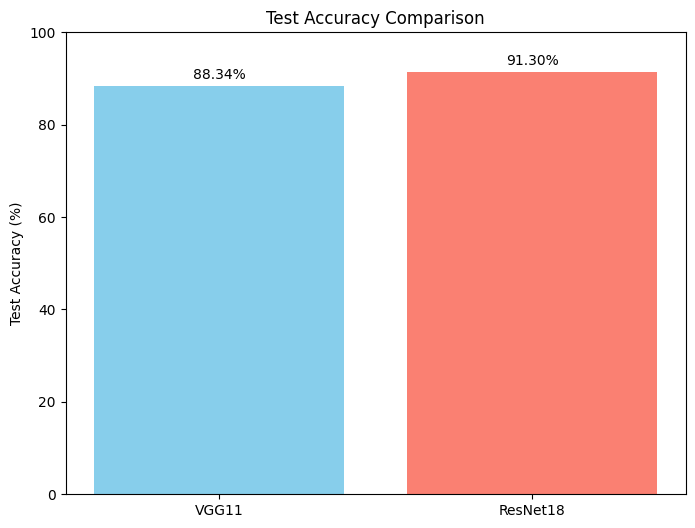

In [12]:
# Visualize Test Performance

# Create a bar chart for test accuracies
models = ['VGG11', 'ResNet18']
test_accuracies = [vgg_test_acc * 100, resnet_test_acc * 100]

plt.figure(figsize=(8,6))
bars = plt.bar(models, test_accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 100)
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()